In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Import D-Wave Ocean SDK components
import dimod
from dimod import BinaryQuadraticModel
from dimod import SimulatedAnnealingSampler


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate a synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                           n_classes=2, random_state=42)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Define hyperparameter choices
hyperparams = {
    'num_layers': [1, 2, 3, 4],                        # Number of hidden layers
    'units_per_layer': [16, 32, 64, 128, 256],         # Units in each layer
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.5],         # Dropout rate
    'learning_rate': [0.001, 0.01, 0.1],               # Learning rate
    'batch_size': [16, 32, 64, 128],                   # Batch size
    'activation': ['relu', 'tanh', 'elu']              # Activation function
}

# Print out the search space size
search_space_size = 1
for param, values in hyperparams.items():
    search_space_size *= len(values)
    
print(f"Total hyperparameter combinations: {search_space_size}")

Training set: 700 samples
Validation set: 150 samples
Test set: 150 samples
Total hyperparameter combinations: 3600


In [3]:
def evaluate_model(hyperparameter_values, X_train, X_val, y_train, y_val):
    """
    Train a neural network with the given hyperparameters and evaluate its F1 score
    
    Returns:
    - f1 score on validation set (to be minimized, so we return -f1 for maximization by the solver)
    """
    num_layers = hyperparameter_values['num_layers']
    units = hyperparameter_values['units_per_layer']
    dropout = hyperparameter_values['dropout_rate']
    lr = hyperparameter_values['learning_rate']
    batch = hyperparameter_values['batch_size']
    act = hyperparameter_values['activation']
    
    # Build model
    model = Sequential()
    model.add(Dense(units, activation=act, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout))
    
    # Add additional layers
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation=act))
        model.add(Dropout(dropout))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    model.fit(
        X_train, y_train,
        batch_size=batch,
        epochs=5,  # Reduced for demonstration
        verbose=0,
        validation_data=(X_val, y_val)
    )
    
    # Predict and calculate F1 score
    y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
    f1 = f1_score(y_val, y_pred)
    
    # We want to minimize -f1 (maximize f1)
    return -f1

def simulate_performance(param, value_idx, hyperparams):
    """
    Simulate the performance impact of a specific hyperparameter choice.
    This is a placeholder for actual evaluations in a real-world scenario.
    
    In practice, you would either:
    1. Pre-evaluate various hyperparameter combinations
    2. Use a surrogate model like Bayesian optimization
    """
    # These mappings simulate the expected impact of each hyperparameter on model performance
    # Positive values indicate better performance (higher F1)
    
    value = hyperparams[param][value_idx]
    
    # Simulate performance impacts based on domain knowledge
    if param == 'num_layers':
        # More layers generally better up to a point (diminishing returns)
        return -0.1 if value == 1 else 0.05 if value == 2 else 0.1 if value == 3 else 0.0
        
    elif param == 'units_per_layer':
        # More units generally better up to a point (diminishing returns)
        return -0.1 if value == 16 else 0.0 if value == 32 else 0.05 if value == 64 else 0.1 if value == 128 else 0.0
        
    elif param == 'dropout_rate':
        # Some dropout helps prevent overfitting, but too much hurts performance
        return -0.05 if value == 0.0 else 0.1 if value == 0.1 or value == 0.2 else 0.0 if value == 0.3 else -0.1
        
    elif param == 'learning_rate':
        # Middle learning rate often works best
        return -0.05 if value == 0.001 else 0.1 if value == 0.01 else -0.1
        
    elif param == 'batch_size':
        # Medium batch sizes often work best
        return 0.0 if value == 16 else 0.1 if value == 32 or value == 64 else 0.05
        
    elif param == 'activation':
        # ReLU often works best for most problems
        return 0.1 if value == 'relu' else 0.0 if value == 'tanh' else 0.05
        
    # Add some random noise to simulate variability in training
    return 0.0 + np.random.normal(0, 0.02)

In [4]:
# Create CQM model
from dimod import ConstrainedQuadraticModel, Binary

# Create a CQM model
cqm = ConstrainedQuadraticModel()

# Create binary variables for each hyperparameter choice
variables = {}
binary_variables = {}

for param, values in hyperparams.items():
    variables[param] = []
    binary_variables[param] = []
    
    for i in range(len(values)):
        var_name = f"{param}_{i}"
        # Tell CQM to add a binary variable
        binary_variable = Binary(var_name)
        #cqm.add_variable(binary_variable)
        variables[param].append(var_name)
        binary_variables[param].append((var_name, binary_variable))  # just store names

objective_terms = []

for param, param_vars in binary_variables.items():
    for i, var_name_tpl in enumerate(param_vars):
        impact = simulate_performance(param, i, hyperparams)
        objective_terms.append(impact * var_name_tpl[1]) 

# Build the objective
cqm.set_objective(sum(objective_terms)) 
## Max F1 with minimum complexity
# min(w1*-F1 + w2*complexity) => Complexity = computational time

# hyperparams = {
#     'num_layers': [1, 2, 3, 4], [0,1,0,0]                       # Number of hidden layers
#     'units_per_layer': [16, 32, 64, 128, 256],  [0,0,0,1]        # Units in each layer
#     'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.5],    [1,0,0,0]      # Dropout rate
#     'learning_rate': [0.001, 0.01, 0.1],    [0,1,0,0]            # Learning rate
#     'batch_size': [16, 32, 64, 128],   [0,0,1,0]                # Batch size
#     'activation': ['relu', 'tanh', 'elu']  [0,0,1,0]          # Activation function
# }

# Next Steps try:
# hyperparams
# cqm.set_objective(evaluate_model(hyperparameter_values, X_train, X_val, y_train, y_val))

# Add constraints to ensure exactly one option is selected per hyperparameter
for param, name_var_list in binary_variables.items():
    var_list = [x[0] for x in name_var_list]
    cqm.add_discrete(var_list, label=f"{param}_constraint")  # pass list of names

print("CQM model created")


CQM model created


In [ ]:
objective_terms[0].

np.float64(-0.1)

In [14]:
# Convert CQM to BQM for local solving
print("Converting CQM to BQM for local solving...")
try:
    # For newer versions of dimod
    bqm = dimod.lp.cqm_to_bqm(cqm)
except Exception as e:
    print(f"Could not use dimod.lp.cqm_to_bqm: {e}")
    # For older versions, we need to handle the conversion manually
    # First, try a built-in conversion if available
    try:
        from dimod.reference.converters import cqm_to_bqm
        bqm = cqm_to_bqm(cqm)
    except Exception as e:
        print(f"Could not use dimod.reference.converters.cqm_to_bqm: {e}")
        # If all else fails, implement manual conversion with penalty method
        bqm = BinaryQuadraticModel('BINARY')
        
        # Add the objective terms using variable names
        for binary_var in objective_terms:
            var_name = binary_var.variables[0]
            bias = binary_var.get_linear(var_name)
            bqm.add_variable(var_name, bias)
        
        # Add constraints with penalty method
        penalty_strength = 10.0  # Make this higher than any objective value
        
        for param, param_vars in variables.items():
            # Add penalty for not selecting exactly one choice
            # (sum(x_i) - 1)^2 = sum(x_i)^2 - 2*sum(x_i) + 1
            
            # Add linear terms: -2*x_i
            for var in param_vars:
                bqm.add_variable(var, -2 * penalty_strength)
            
            # Add quadratic terms: x_i * x_j (for i != j)
            for i, var_i in enumerate(param_vars):
                for j, var_j in enumerate(param_vars):
                    if i < j:  # Only add interaction between different variables
                        bqm.add_interaction(var_i, var_j, penalty_strength)
                        
            # Add constant term (1) to the offset
            bqm.offset += penalty_strength

print("BQM model created for local solving")

# Use simulated annealing to solve the BQM
sampler = SimulatedAnnealingSampler()
print("Solving with simulated annealing...")

# Sample the BQM
sampleset = sampler.sample(bqm, num_reads=1000)

# Get the best solution
best_sample = sampleset.first.sample
best_energy = sampleset.first.energy

print(f"Best energy found: {best_energy}")

# Extract the selected hyperparameters
selected_hyperparams = {}
for param, param_vars in variables.items():
    param_count = 0
    for i, var in enumerate(param_vars):
        if var in best_sample and best_sample[var] == 1:
            selected_hyperparams[param] = hyperparams[param][i]
            param_count += 1
    
    # Verify constraint satisfaction
    if param_count != 1:
        print(f"Warning: Constraint violation for {param} - selected {param_count} options")

print("\nOptimized Hyperparameters:")
for param, value in selected_hyperparams.items():
    print(f"{param}: {value}")


Converting CQM to BQM for local solving...
Could not use dimod.lp.cqm_to_bqm: module 'dimod.lp' has no attribute 'cqm_to_bqm'
Could not use dimod.reference.converters.cqm_to_bqm: No module named 'dimod.reference.converters'
BQM model created for local solving
Solving with simulated annealing...
Best energy found: -120.39999999999998

Optimized Hyperparameters:
num_layers: 4
units_per_layer: 256
dropout_rate: 0.5
learning_rate: 0.1
batch_size: 128
activation: elu


Training neural network with optimized hyperparameters...

Optimized Model Architecture:
- Input Layer: 20 features
- Hidden Layer 1: 256 units, elu activation, 0.5 dropout
- Hidden Layer 2: 256 units, elu activation, 0.5 dropout
- Hidden Layer 3: 256 units, elu activation, 0.5 dropout
- Hidden Layer 4: 256 units, elu activation, 0.5 dropout
- Output Layer: 1 unit (sigmoid activation)
- Learning rate: 0.1
- Batch size: 128
Epoch 1/20


/Users/calogerozarbo/miniconda3/envs/quantum_hypterparameter_search/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4978 - loss: 235.7914 - val_accuracy: 0.4000 - val_loss: 57.5089
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5264 - loss: 53.3926 - val_accuracy: 0.5333 - val_loss: 9.8558
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6176 - loss: 48.1366 - val_accuracy: 0.6200 - val_loss: 8.5680
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6381 - loss: 49.5488 - val_accuracy: 0.6067 - val_loss: 2.2321
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6383 - loss: 31.5907 - val_accuracy: 0.6200 - val_loss: 2.2373
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6373 - loss: 20.5050 - val_accuracy: 0.5267 - val_loss: 2.6290
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6231 - loss: 13.8179 - val_accuracy: 0.5333 - val_loss: 2.9385
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6263 - loss: 17.2571 - val_accuracy: 0.4733 - val_loss: 1.2221
Epoch 9/

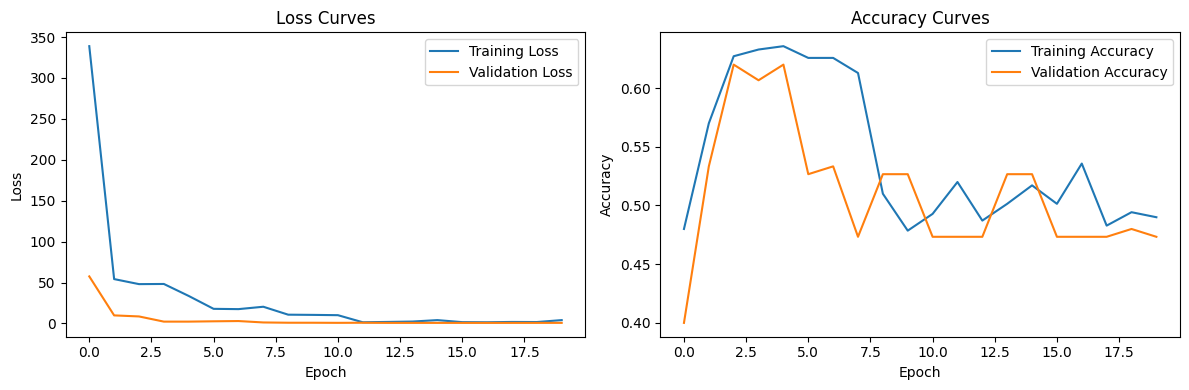

Training Simple model...


/Users/calogerozarbo/miniconda3/envs/quantum_hypterparameter_search/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Simple model F1 score: 0.9412
Training Complex model...


/Users/calogerozarbo/miniconda3/envs/quantum_hypterparameter_search/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x166bf6cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Complex model F1 score: 0.9272


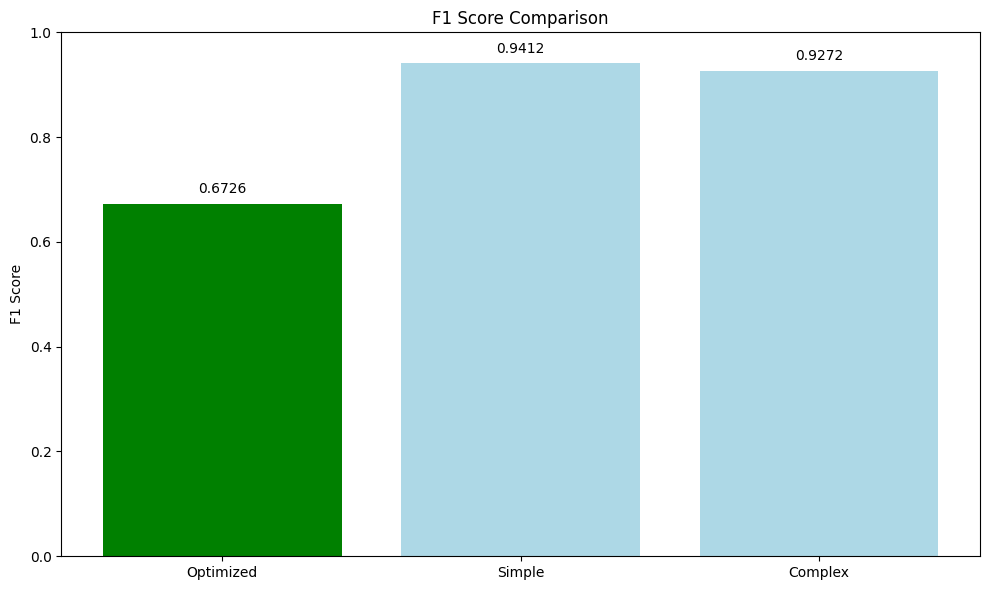


Conclusion:
In this script, we've demonstrated how to use D-Wave's Ocean SDK to optimize hyperparameters
for a neural network using a binary quadratic model (BQM) approach.
We represented hyperparameter choices as binary variables in a BQM, used penalty terms
to ensure exactly one choice per hyperparameter, and then solved it using a local solver.
This approach allows us to efficiently search through a large hyperparameter space to find
optimal or near-optimal configurations for neural networks without having to try every possible combination.


In [15]:
# Check if all hyperparameters were selected
all_hyperparams_selected = all(param in selected_hyperparams for param in hyperparams)

if all_hyperparams_selected:
    # Train a model with the optimized hyperparameters
    print("Training neural network with optimized hyperparameters...")
    
    # Build optimized model
    opt_num_layers = selected_hyperparams['num_layers']
    opt_units = selected_hyperparams['units_per_layer']
    opt_dropout = selected_hyperparams['dropout_rate']
    opt_lr = selected_hyperparams['learning_rate']
    opt_batch = selected_hyperparams['batch_size']
    opt_act = selected_hyperparams['activation']
    
    # Print model architecture
    print(f"\nOptimized Model Architecture:")
    print(f"- Input Layer: {X_train.shape[1]} features")
    for i in range(opt_num_layers):
        print(f"- Hidden Layer {i+1}: {opt_units} units, {opt_act} activation, {opt_dropout} dropout")
    print(f"- Output Layer: 1 unit (sigmoid activation)")
    print(f"- Learning rate: {opt_lr}")
    print(f"- Batch size: {opt_batch}")
    
    # Build model
    opt_model = Sequential()
    opt_model.add(Dense(opt_units, activation=opt_act, input_shape=(X_train.shape[1],)))
    opt_model.add(Dropout(opt_dropout))
    
    # Add additional layers
    for _ in range(opt_num_layers - 1):
        opt_model.add(Dense(opt_units, activation=opt_act))
        opt_model.add(Dropout(opt_dropout))
        
    # Output layer
    opt_model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    opt_model.compile(
        optimizer=Adam(learning_rate=opt_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = opt_model.fit(
        X_train, y_train,
        batch_size=opt_batch,
        epochs=20,
        verbose=1,
        validation_data=(X_val, y_val)
    )
    
    # Evaluate on test set
    y_pred = (opt_model.predict(X_test) > 0.5).astype(int).flatten()
    test_f1 = f1_score(y_test, y_pred)
    
    print(f"\nTest Set F1 Score: {test_f1:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not train model - some hyperparameters were not selected.")

def train_and_evaluate(hyperparams_dict):
    """Train and evaluate a model with the given hyperparameters"""
    # Build model
    model = Sequential()
    model.add(Dense(hyperparams_dict['units_per_layer'], 
                     activation=hyperparams_dict['activation'], 
                     input_shape=(X_train.shape[1],)))
    model.add(Dropout(hyperparams_dict['dropout_rate']))
    
    # Add additional layers
    for _ in range(hyperparams_dict['num_layers'] - 1):
        model.add(Dense(hyperparams_dict['units_per_layer'], 
                         activation=hyperparams_dict['activation']))
        model.add(Dropout(hyperparams_dict['dropout_rate']))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hyperparams_dict['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    model.fit(
        X_train, y_train,
        batch_size=hyperparams_dict['batch_size'],
        epochs=20,
        verbose=0,
        validation_data=(X_val, y_val)
    )
    
    # Predict and calculate F1 score
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    f1 = f1_score(y_test, y_pred)
    
    return f1

if all_hyperparams_selected:
    # Define some baseline configurations
    baseline_configs = [
        # Simple model
        {
            'name': 'Simple',
            'num_layers': 1,
            'units_per_layer': 32,
            'dropout_rate': 0.2,
            'learning_rate': 0.01,
            'batch_size': 32,
            'activation': 'relu'
        },
        # Complex model
        {
            'name': 'Complex',
            'num_layers': 4,
            'units_per_layer': 256,
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'batch_size': 64,
            'activation': 'tanh'
        }
    ]
    
    # Prepare for comparison
    model_names = ['Optimized'] + [config['name'] for config in baseline_configs]
    f1_scores = [test_f1]
    
    # Train and evaluate baseline models
    for config in baseline_configs:
        print(f"Training {config['name']} model...")
        f1 = train_and_evaluate(config)
        f1_scores.append(f1)
        print(f"{config['name']} model F1 score: {f1:.4f}")
    
    # Compare performances
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, f1_scores, color=['green'] + ['lightblue'] * len(baseline_configs))
    plt.title('F1 Score Comparison')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    for i, score in enumerate(f1_scores):
        plt.text(i, score + 0.02, f"{score:.4f}", ha='center')
    plt.tight_layout()
    plt.show()

print("\nConclusion:")
print("In this script, we've demonstrated how to use D-Wave's Ocean SDK to optimize hyperparameters")
print("for a neural network using a binary quadratic model (BQM) approach.")
print("We represented hyperparameter choices as binary variables in a BQM, used penalty terms")
print("to ensure exactly one choice per hyperparameter, and then solved it using a local solver.")
print("This approach allows us to efficiently search through a large hyperparameter space to find")
print("optimal or near-optimal configurations for neural networks without having to try every possible combination.")
